# Shape Free Reconstruction via Style Transfer Loss
## to Reconstruct Generated Image to get near the Ground truth ?

## ###############################################*100

# Prcoedure 
## Build Model
## Trainig in Batch
While Training:
    Pick Mask  image 
    Looping for n_iteration
        Pick batch_size images.
        Generate Images (# = batch_size
        Create Training Data 
        
        fit in NN to traing for 50 times 

End While till converge 




In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
from keras import Model

import matplotlib.pyplot as plt
import cv2
from random import randint
import subprocess

from keras.layers import Input,Conv2D,Subtract, Lambda
%matplotlib inline
from keras.models import load_model
import os
import keras.backend as K
import random
from random import randint
from shape_free_conv import build_model # model definition and build is here



Using TensorFlow backend.


# Build Model (4 layer fully convolution CNN)

## Will Change LOss structure..layer near out put should have larger loss .
## should have style loss (layer 1-4), content loss(layer4), reconstruction loss (output layer)
current: for  layer 1-4 , should use gram_ matrix as style loss, but bugs happen...use MSE instead

In [2]:


def create_label(batch_size,ch,H,W,y,n_layer=5):
    label = []
    for i in range (1,n_layer):
        label.append(np.zeros(shape=[batch_size,ch*i,ch*i]))
    label.append (np.zeros(shape=[batch_size,3,3]))
    label.append (y)
    return label


# crete label with ALL Zero's fo rlater fit usage
# The label list depends on batch_sie, channel, Height, width, and layer size
def create_label(batch_size,ch,H,W,n_layer=5):
    label = []
    for i in range (1,n_layer):
        label.append(np.zeros(shape=[batch_size,ch*i,ch*i]))
    label.append (np.zeros(shape=[batch_size,H,W,3]))
    return label

# Train 
## 1 mask to fit  many True Images (According to batch_size)
## Procedure: 
## Chosse 1 Mask 
## Choose 8 images
## Gerenate 8 images 
## Generate 8 batch data

In [3]:

def generate_mask_list():

    # genreate mask, Note, for each image we will genreate 5 masks

    mask_list = [] # will genreate lts of masks and stored in mask_list

    num_mask = 10000


    for i in range(num_mask):

        x,y = np.random.randint(-30,30,size=2) # random 選取mask start point , x,y = 左上角座標
        w,h = np.random.randint(60,128,size=2) # ensure maks area 不會小於 50  也不會大於128
        mask_list.append((x,y,w,h))

    return mask_list

In [4]:
def generate_same_size_mask():
    # genreate mask, Note, for each image we will genreate 5 masks

    mask_list = [] # will genreate lts of masks and stored in mask_list

    num_mask = 10000
    w,h = np.random.randint(50,128,size=2) # ensure maks area 不會小於 50  也不會大於128

    for i in range(num_mask):

        x,y = np.random.randint(-30,30,size=2) # random 選取mask start point , x,y = 左上角座標
        
        mask_list.append((x,y,w,h))
    return mask_list


In [5]:

def choose_mask(mask_list):

    mask = np.zeros((256,256,3)).astype('uint8')

    choose = randint(0,9999)
    area = mask_list[choose]
    x,y,w,h = area
    print (x,y,w,h)
    #mask[x:x+w,y:y+h,:]=255
    mask[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]=255  # masked area = 1
    plt.imshow(mask)
    return area, mask



# 1 mask for many images 

def generate_train_img(mask,area, src,ep,bacth_size, low=1,high=890):

    x,y,w,h =area
    true_img_batch = []
    masked_img_batch = []
    output_img_batch = []

    cv2.imwrite(src+'mask'+str(ep)+'.png', mask)
    mask_path = src+'mask'+str(ep)+'.png'


    pick_list = random.sample(range(low, high), batch_size)  # pick an image from 1 to 895
    for pick in pick_list:
        true_img_path =  src+'masked_img' +str(pick) + '.jpg'
        true_img = cv2.imread(src+str(pick)+'.jpg')
        true_img_batch.append  (true_img)
        plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))

        masked_img = true_img.copy()
        masked_img[mask > 0] = 255
        cv2.imwrite(src+'masked_img'+str(pick)+'.jpg', masked_img)
        masked_img_path = src+'masked_img'+str(pick)+'.jpg'



        output_img_path= src+'output'+str(pick)+'.png'


        # here should change ....too many times load model
        subprocess.call(f"python test.py --image {masked_img_path} --mask {mask_path} \
        --output {output_img_path} --checkpoint_dir model_logs/release_imagenet_256 ", shell=True)


        # save mask
        output_img =cv2.imread(output_img_path)
        output_img_batch.append(output_img)

    true_img_batch =  np.array(true_img_batch)
    output_img_batch =  np.array(output_img_batch)

    print ('shape of true img, output img', true_img_batch.shape,  output_img_batch.shape)

    train_true = true_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.
    train_output = output_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.

    print ('shape of true area, output area', train_true.shape,  train_output.shape)

    return train_true, train_output




In [6]:

# 1 image  for many masks

def generate_1_img_train(generate_same_size_mask, img_no, src,bacth_size):
    mask_list =  generate_same_size_mask()
    
    area_list = random.sample(mask_list, batch_size)  # pick masks with batch_size, from mask_list same size

    true_img_path =  src+str(img_no)+'.jpg'
    true_img = cv2.imread(src+str(img_no)+'.jpg')

    true_img_batch = [true_img]*bacth_size
 
    output_img_batch = []


    for i,area in enumerate(area_list):
        mask = np.zeros((256,256,3)).astype('uint8')
        x,y,w,h = area
        print (x,y,w,h)
        #mask[x:x+w,y:y+h,:]=255
        mask[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]=255  # masked area = 1

        cv2.imwrite(src+'mask'+str(i)+'.png', mask)
        mask_path = src+'mask'+str(i)+'.png'


        masked_img = true_img.copy()
        masked_img[mask > 0] = 255
        cv2.imwrite(src+'masked_img'+str(i)+'.jpg', masked_img)
        masked_img_path = src+'masked_img'+str(i)+'.jpg'



        output_img_path= src+'output'+str(i)+'.png'


        # here should change ....too many times load model
        subprocess.call(f"python test.py --image {masked_img_path} --mask {mask_path} \
        --output {output_img_path} --checkpoint_dir model_logs/release_imagenet_256 ", shell=True)


        # save mask
        output_img =cv2.imread(output_img_path)
        output_img_batch.append(output_img)

    true_img_batch =  np.array(true_img_batch)
    output_img_batch =  np.array(output_img_batch)

    print ('shape of true img, output img', true_img_batch.shape,  output_img_batch.shape)

    train_true = true_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.
    train_output = output_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.

    print ('shape of true area, output area', train_true.shape,  train_output.shape)
    print ('train true max, min', np.max(train_true),np.min(train_true))
    print ('train output max, min', np.max(train_output),np.min(train_output))
    return area,train_true, train_output

In [32]:
# if need weigthed loss add loss weight and recompile
# Network model and loss

#weight_list = [10.0]*4 + [1.0]


batch_size = 1

src= '/Users/LarryGuo/Desktop/nano_degree/Capstone_PixNet/generative_inpainting-master/cakes/'  # you should change your dircetory


epoch = 20 # (how many epoch)

iter = 10  # for each image how many masks iter training

ch = 32

model = build_model(batch_size,ch)

if os.path.isfile('4_layer_cnn_1_img_n_mask'):

    model.load_weights('4_layer_cnn_1_img_n_mask')
    
weight = True

if weight:
    loss_weights = [0.001,0.02,0.2,0.1,1.,1.0]

    model.compile(optimizer='Adam', loss=['mse']*6, loss_weights=loss_weights)
    model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, None, None, 3 12          input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, None, None, 3 12          input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_21 

In [34]:
# Start training netwokr 


area,train_true,train_output  = generate_1_img_train(generate_same_size_mask, img_no,src,batch_size)  # no change of img, mask

for ep in range(epoch):
    img_no = 335
    
    print ('epoch =', ep, 'img_no=', img_no)
    
    #area,mask = choose_mask(generate_mask_list())  # 1 mask

  
    #train_true,train_output  = generate_train_img(mask, area,src,ep,batch_size)
    
    x,y,w,h =area
    H,W = train_true.shape[1:3]

    label = create_label(batch_size,ch,H,W,train_true,n_layer=5)
    print ([l.shape for l in label])

    # for each img, train 50 times
    model.fit([train_output,train_true],label,epochs=20,verbose=1)
    model.save('4_layer_cnn_1_img_n_mask')
    print ('\n*********\n')
    print ('epochs = ', ep, 'model saved')
    print ('\n*********\n')



1 8 115 74
shape of true img, output img (1, 256, 256, 3) (1, 256, 256, 3)
shape of true area, output area (1, 114, 74, 3) (1, 114, 74, 3)
train true max, min 1.0 0.0
train output max, min 1.0 0.0
epoch = 0 img_no= 335
[(1, 32, 32), (1, 64, 64), (1, 96, 96), (1, 128, 128), (1, 3, 3), (1, 114, 74, 3)]
Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 3263.5261 - subtract_21_loss: 3041.3318 - subtract_22_loss: 86808.8594 - subtract_23_loss: 5966.4155 - subtract_24_loss: 1217.4224 - subtract_25_loss: 209.1853 - conv2d_25_loss: 0.0972
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 3896.2935 - subtract_21_loss: 3135.7568 - subtract_22_loss: 29976.8008 - subtract_23_loss: 1447.6143 - subtract_24_loss: 1086.4176 - subtract_25_loss: 2895.3464 - conv2d_25_loss: 0.1106
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 1150.6971 - subtract_21_loss: 3212.6641 - subtract_22_loss: 15337.4883 - subtract_23_loss: 1770.2793 - subtract_24_loss:

Epoch 12/20
1/1 [==============================] - 2s 2s/step - loss: 178.0724 - subtract_21_loss: 3922.6287 - subtract_22_loss: 3009.9636 - subtract_23_loss: 363.9698 - subtract_24_loss: 401.1035 - subtract_25_loss: 0.9443 - conv2d_25_loss: 0.1019
Epoch 13/20
1/1 [==============================] - 2s 2s/step - loss: 169.5258 - subtract_21_loss: 3918.4211 - subtract_22_loss: 2874.8062 - subtract_23_loss: 337.2895 - subtract_24_loss: 391.9774 - subtract_25_loss: 1.3536 - conv2d_25_loss: 0.1020
Epoch 14/20
1/1 [==============================] - 2s 2s/step - loss: 159.1464 - subtract_21_loss: 3913.2710 - subtract_22_loss: 2734.0405 - subtract_23_loss: 311.1316 - subtract_24_loss: 379.9296 - subtract_25_loss: 0.2309 - conv2d_25_loss: 0.1021
Epoch 15/20
1/1 [==============================] - 2s 2s/step - loss: 151.4580 - subtract_21_loss: 3907.9961 - subtract_22_loss: 2600.0815 - subtract_23_loss: 292.9111 - subtract_24_loss: 362.5476 - subtract_25_loss: 0.6092 - conv2d_25_loss: 0.1022
Epoc

Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 66.4372 - subtract_21_loss: 3649.0229 - subtract_22_loss: 1109.1328 - subtract_23_loss: 117.7965 - subtract_24_loss: 169.1032 - subtract_25_loss: 0.0318 - conv2d_25_loss: 0.1041
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 65.2866 - subtract_21_loss: 3637.3662 - subtract_22_loss: 1090.1935 - subtract_23_loss: 115.4309 - subtract_24_loss: 166.2457 - subtract_25_loss: 0.0304 - conv2d_25_loss: 0.1042
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 64.1571 - subtract_21_loss: 3625.9231 - subtract_22_loss: 1071.1390 - subtract_23_loss: 113.1594 - subtract_24_loss: 163.6006 - subtract_25_loss: 0.0123 - conv2d_25_loss: 0.1042
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 63.1115 - subtract_21_loss: 3614.6597 - subtract_22_loss: 1052.0061 - subtract_23_loss: 111.0711 - subtract_24_loss: 161.0642 - subtract_25_loss: 0.0319 - conv2d_25_loss: 0.1042
Epoch 8/20
1

Epoch 17/20
1/1 [==============================] - 2s 2s/step - loss: 43.3505 - subtract_21_loss: 3305.5171 - subtract_22_loss: 726.9063 - subtract_23_loss: 72.9156 - subtract_24_loss: 108.1861 - subtract_25_loss: 5.5813e-04 - conv2d_25_loss: 0.1045
Epoch 18/20
1/1 [==============================] - 2s 2s/step - loss: 42.9292 - subtract_21_loss: 3296.1099 - subtract_22_loss: 719.9782 - subtract_23_loss: 72.1449 - subtract_24_loss: 106.9905 - subtract_25_loss: 9.8495e-04 - conv2d_25_loss: 0.1045
Epoch 19/20
1/1 [==============================] - 2s 2s/step - loss: 42.5148 - subtract_21_loss: 3286.7566 - subtract_22_loss: 713.3021 - subtract_23_loss: 71.3668 - subtract_24_loss: 105.8228 - subtract_25_loss: 0.0018 - conv2d_25_loss: 0.1046
Epoch 20/20
1/1 [==============================] - 2s 2s/step - loss: 42.1059 - subtract_21_loss: 3277.4902 - subtract_22_loss: 706.8801 - subtract_23_loss: 70.5940 - subtract_24_loss: 104.6613 - subtract_25_loss: 0.0013 - conv2d_25_loss: 0.1046

*******

Epoch 9/20
1/1 [==============================] - 2s 2s/step - loss: 33.0017 - subtract_21_loss: 3032.9553 - subtract_22_loss: 563.8312 - subtract_23_loss: 53.4218 - subtract_24_loss: 78.9286 - subtract_25_loss: 0.0102 - conv2d_25_loss: 0.1047
Epoch 10/20
1/1 [==============================] - 2s 2s/step - loss: 32.7677 - subtract_21_loss: 3025.1650 - subtract_22_loss: 560.0249 - subtract_23_loss: 52.9689 - subtract_24_loss: 78.2388 - subtract_25_loss: 0.0196 - conv2d_25_loss: 0.1047
Epoch 11/20
1/1 [==============================] - 2s 2s/step - loss: 32.5478 - subtract_21_loss: 3017.4373 - subtract_22_loss: 556.2079 - subtract_23_loss: 52.5309 - subtract_24_loss: 77.5472 - subtract_25_loss: 0.0406 - conv2d_25_loss: 0.1047
Epoch 12/20
1/1 [==============================] - 2s 2s/step - loss: 32.3581 - subtract_21_loss: 3009.7368 - subtract_22_loss: 552.5124 - subtract_23_loss: 52.0952 - subtract_24_loss: 76.8835 - subtract_25_loss: 0.0860 - conv2d_25_loss: 0.1047
Epoch 13/20
1/1 [====

Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 35.7832 - subtract_21_loss: 2787.1868 - subtract_22_loss: 479.2384 - subtract_23_loss: 57.3643 - subtract_24_loss: 83.3457 - subtract_25_loss: 3.5036 - conv2d_25_loss: 0.1002
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 33.9882 - subtract_21_loss: 2780.2720 - subtract_22_loss: 478.1335 - subtract_23_loss: 56.2661 - subtract_24_loss: 82.6515 - subtract_25_loss: 2.0267 - conv2d_25_loss: 0.1002
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 35.0340 - subtract_21_loss: 2773.3262 - subtract_22_loss: 476.6765 - subtract_23_loss: 54.5771 - subtract_24_loss: 81.4513 - subtract_25_loss: 3.5663 - conv2d_25_loss: 0.1003
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 32.3638 - subtract_21_loss: 2767.7871 - subtract_22_loss: 471.9643 - subtract_23_loss: 53.1113 - subtract_24_loss: 80.0948 - subtract_25_loss: 1.4247 - conv2d_25_loss: 0.1003
Epoch 6/20
1/1 [========

Epoch 15/20
1/1 [==============================] - 2s 2s/step - loss: 23.0895 - subtract_21_loss: 2600.9258 - subtract_22_loss: 393.7441 - subtract_23_loss: 35.0838 - subtract_24_loss: 54.5454 - subtract_25_loss: 0.0421 - conv2d_25_loss: 0.1003
Epoch 16/20
1/1 [==============================] - 2s 2s/step - loss: 22.9704 - subtract_21_loss: 2595.0835 - subtract_22_loss: 391.8445 - subtract_23_loss: 34.8064 - subtract_24_loss: 53.9971 - subtract_25_loss: 0.0771 - conv2d_25_loss: 0.1003
Epoch 17/20
1/1 [==============================] - 2s 2s/step - loss: 22.7848 - subtract_21_loss: 2589.3315 - subtract_22_loss: 389.9068 - subtract_23_loss: 34.5273 - subtract_24_loss: 53.4476 - subtract_25_loss: 0.0467 - conv2d_25_loss: 0.1003
Epoch 18/20
1/1 [==============================] - 2s 2s/step - loss: 22.6651 - subtract_21_loss: 2583.7285 - subtract_22_loss: 387.9974 - subtract_23_loss: 34.2706 - subtract_24_loss: 52.9128 - subtract_25_loss: 0.0756 - conv2d_25_loss: 0.1004
Epoch 19/20
1/1 [===

Epoch 8/20
1/1 [==============================] - 2s 2s/step - loss: 34.9367 - subtract_21_loss: 2416.9746 - subtract_22_loss: 340.4048 - subtract_23_loss: 28.6018 - subtract_24_loss: 41.8925 - subtract_25_loss: 15.7014 - conv2d_25_loss: 0.1006
Epoch 9/20
1/1 [==============================] - 2s 2s/step - loss: 36.0368 - subtract_21_loss: 2412.2107 - subtract_22_loss: 339.0714 - subtract_23_loss: 28.5384 - subtract_24_loss: 41.7952 - subtract_25_loss: 16.8555 - conv2d_25_loss: 0.1005
Epoch 10/20
1/1 [==============================] - 2s 2s/step - loss: 29.4105 - subtract_21_loss: 2405.9324 - subtract_22_loss: 338.1839 - subtract_23_loss: 28.4231 - subtract_24_loss: 41.5400 - subtract_25_loss: 10.3016 - conv2d_25_loss: 0.1007
Epoch 11/20
1/1 [==============================] - 2s 2s/step - loss: 20.7317 - subtract_21_loss: 2401.0671 - subtract_22_loss: 337.0992 - subtract_23_loss: 28.4290 - subtract_24_loss: 41.4336 - subtract_25_loss: 1.6589 - conv2d_25_loss: 0.1005
Epoch 12/20
1/1 [==


*********

epochs =  12 model saved

*********

epoch = 13 img_no= 335
[(1, 32, 32), (1, 64, 64), (1, 96, 96), (1, 128, 128), (1, 3, 3), (1, 114, 74, 3)]
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 16.8005 - subtract_21_loss: 2252.0200 - subtract_22_loss: 302.5476 - subtract_23_loss: 24.6842 - subtract_24_loss: 34.5559 - subtract_25_loss: 0.0050 - conv2d_25_loss: 0.1002
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 16.9214 - subtract_21_loss: 2247.4409 - subtract_22_loss: 301.4431 - subtract_23_loss: 24.5451 - subtract_24_loss: 34.3475 - subtract_25_loss: 0.2012 - conv2d_25_loss: 0.1002
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 16.9465 - subtract_21_loss: 2242.6060 - subtract_22_loss: 300.4370 - subtract_23_loss: 24.4039 - subtract_24_loss: 34.1342 - subtract_25_loss: 0.3007 - conv2d_25_loss: 0.1002
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 16.6612 - subtract_21_loss: 2238.0901 - subt

Epoch 14/20
1/1 [==============================] - 2s 2s/step - loss: 15.3402 - subtract_21_loss: 2107.2446 - subtract_22_loss: 272.1723 - subtract_23_loss: 21.5725 - subtract_24_loss: 29.7783 - subtract_25_loss: 0.3972 - conv2d_25_loss: 0.1000
Epoch 15/20
1/1 [==============================] - 2s 2s/step - loss: 16.2082 - subtract_21_loss: 2102.8169 - subtract_22_loss: 271.1648 - subtract_23_loss: 21.4715 - subtract_24_loss: 29.5965 - subtract_25_loss: 1.3283 - conv2d_25_loss: 0.0999
Epoch 16/20
1/1 [==============================] - 2s 2s/step - loss: 16.3334 - subtract_21_loss: 2098.6860 - subtract_22_loss: 270.1153 - subtract_23_loss: 21.4448 - subtract_24_loss: 29.4464 - subtract_25_loss: 1.4989 - conv2d_25_loss: 0.0999
Epoch 17/20
1/1 [==============================] - 2s 2s/step - loss: 15.1994 - subtract_21_loss: 2094.1289 - subtract_22_loss: 269.3503 - subtract_23_loss: 21.3878 - subtract_24_loss: 29.2370 - subtract_25_loss: 0.4171 - conv2d_25_loss: 0.0999
Epoch 18/20
1/1 [===

Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 14.8058 - subtract_21_loss: 1973.2275 - subtract_22_loss: 244.4687 - subtract_23_loss: 18.6891 - subtract_24_loss: 24.4056 - subtract_25_loss: 1.6648 - conv2d_25_loss: 0.0999
Epoch 8/20
1/1 [==============================] - 2s 2s/step - loss: 14.4985 - subtract_21_loss: 1969.7971 - subtract_22_loss: 243.8201 - subtract_23_loss: 18.5957 - subtract_24_loss: 24.2855 - subtract_25_loss: 1.4047 - conv2d_25_loss: 0.0999
Epoch 9/20
1/1 [==============================] - 2s 2s/step - loss: 13.8831 - subtract_21_loss: 1965.7427 - subtract_22_loss: 243.1960 - subtract_23_loss: 18.5242 - subtract_24_loss: 24.1518 - subtract_25_loss: 0.8336 - conv2d_25_loss: 0.0999
Epoch 10/20
1/1 [==============================] - 2s 2s/step - loss: 13.3111 - subtract_21_loss: 1962.2239 - subtract_22_loss: 242.5374 - subtract_23_loss: 18.4396 - subtract_24_loss: 24.0279 - subtract_25_loss: 0.3075 - conv2d_25_loss: 0.0999
Epoch 11/20
1/1 [======

Epoch 20/20
1/1 [==============================] - 1s 1s/step - loss: 12.9601 - subtract_21_loss: 1848.0382 - subtract_22_loss: 226.0435 - subtract_23_loss: 17.0619 - subtract_24_loss: 22.3837 - subtract_25_loss: 0.8414 - conv2d_25_loss: 0.0991

*********

epochs =  17 model saved

*********

epoch = 18 img_no= 335
[(1, 32, 32), (1, 64, 64), (1, 96, 96), (1, 128, 128), (1, 3, 3), (1, 114, 74, 3)]
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 12.1876 - subtract_21_loss: 1844.3274 - subtract_22_loss: 225.3542 - subtract_23_loss: 16.9219 - subtract_24_loss: 22.2320 - subtract_25_loss: 0.1295 - conv2d_25_loss: 0.0991
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 12.8659 - subtract_21_loss: 1841.0857 - subtract_22_loss: 224.4174 - subtract_23_loss: 16.7708 - subtract_24_loss: 22.0798 - subtract_25_loss: 0.8752 - conv2d_25_loss: 0.0992
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 12.3952 - subtract_21_loss: 1837.3425 - sub

Epoch 13/20
1/1 [==============================] - 1s 1s/step - loss: 15.5593 - subtract_21_loss: 1738.8403 - subtract_22_loss: 205.9233 - subtract_23_loss: 15.0115 - subtract_24_loss: 18.3525 - subtract_25_loss: 4.7656 - conv2d_25_loss: 0.0988
Epoch 14/20
1/1 [==============================] - 1s 1s/step - loss: 16.2605 - subtract_21_loss: 1737.0679 - subtract_22_loss: 205.3970 - subtract_23_loss: 14.9525 - subtract_24_loss: 18.2365 - subtract_25_loss: 5.5025 - conv2d_25_loss: 0.0988
Epoch 15/20
1/1 [==============================] - 2s 2s/step - loss: 17.0944 - subtract_21_loss: 1732.7448 - subtract_22_loss: 205.1221 - subtract_23_loss: 14.9212 - subtract_24_loss: 18.2214 - subtract_25_loss: 6.3539 - conv2d_25_loss: 0.0989
Epoch 16/20
1/1 [==============================] - 2s 2s/step - loss: 19.0170 - subtract_21_loss: 1730.9688 - subtract_22_loss: 204.8783 - subtract_23_loss: 14.8626 - subtract_24_loss: 18.2406 - subtract_25_loss: 8.2931 - conv2d_25_loss: 0.0988
Epoch 17/20
1/1 [===

# After model saved, could do Inference


In [ ]:
# choosing an image 

1 8 115 74


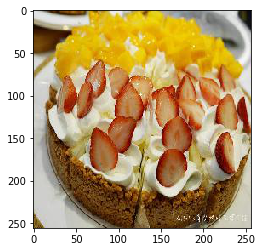

In [35]:
mask = np.zeros((256,256,3)).astype('uint8')
#mask_list = generate_mask_list()
#choose_mask = randint(0,9999)
#x,y,w,h = mask_list[choose_mask]
print (x,y,w,h) # inherit from training.
#mask[x:x+w,y:y+h,:]=255  


mask[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]=255  # masked area = 1
plt.imshow(mask)

# save mask
cv2.imwrite(src+'mask'+str(img_no)+'.png', mask)
mask_path = src+'mask'+str(img_no)+'.png'


true_img_path =  src+str(img_no)+'.jpg'
true_img = cv2.imread(src+str(img_no)+'.jpg')
plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))
#plt.show()


masked_img = true_img.copy()
masked_img[mask > 0] = 255
cv2.imwrite(src+'masked_img'+str(img_no)+'.jpg', masked_img)
masked_img_path = src+'masked_img'+str(img_no)+'.jpg'
output_img_path= src+'output'+str(img_no)+'.png'


# here should change ....too many times load model 
subprocess.call(f"python test.py --image {masked_img_path} --mask {mask_path} \
--output {output_img_path} --checkpoint_dir model_logs/release_imagenet_256 ", shell=True)

output_img =  cv2.imread(output_img_path)


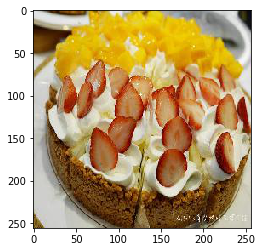

In [36]:
# show true image
plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))

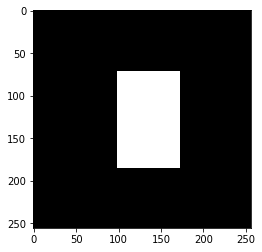

In [37]:
# show mask
plt.imshow(mask)

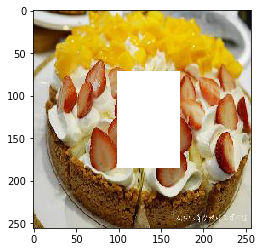

In [38]:
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))

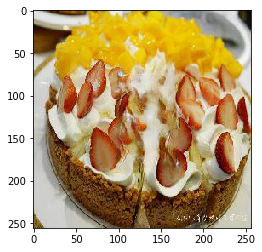

In [39]:
# show generated image
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

In [40]:
generated_img_area = output_img[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.
print (generated_img_area.shape)
test = generated_img_area[:,:,0]
generated_img_area = generated_img_area[np.newaxis,:,:,:]

print (generated_img_area.shape)

(114, 74, 3)
(1, 114, 74, 3)


In [41]:
# load model and do inference 
size =1
ch=32

model = build_model(size,ch)


model.load_weights('4_layer_cnn_1_img_n_mask')

improved_area = model.predict ([generated_img_area]*2)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, None, None, 3 12          input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, None, None, 3 12          input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_26 

In [42]:

print (len(improved_area))
print (improved_area[-1].shape)
print (np.max(improved_area[-1]), np.min(improved_area[-1]))
improved_img = np.round(np.squeeze(improved_area[-1]*255.)).astype(int)
print (improved_img.dtype)
print (np.max(improved_img), np.min(improved_img))

print ('*\n',improved_img.shape)

true_img_area = true_img[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]


print ('\n')
print (improved_img[:,:,0])
print ('\n')

print (true_img_area[:,:,0])
print ('\n')
print (np.round(test*255.))


6
(1, 114, 74, 3)
1.0 0.0
int64
255 0
*
 (114, 74, 3)


[[ 62 108 161 ... 133  95 122]
 [140 177 182 ... 196  52  47]
 [254 134 190 ... 237 114 207]
 ...
 [109 107 149 ... 155 113 127]
 [ 76 201  89 ... 173 114 109]
 [ 66 174 126 ... 139 104 102]]


[[ 93  92  86 ...  16  37  36]
 [ 94  94  89 ...  27  38  49]
 [ 95  95  93 ...  36  30  55]
 ...
 [134 171 154 ...  59  57  57]
 [155 159 167 ...  69  57  72]
 [166 168 169 ...  59  73  63]]


[[ 98. 133. 136. ...  58.  61.  73.]
 [109. 197. 192. ...  65.  79.  97.]
 [104. 168. 234. ...  81.  90. 119.]
 ...
 [159. 185. 184. ... 105.  74.  61.]
 [170. 189. 151. ... 110.  75.  71.]
 [179. 174. 192. ...  85.  81.  84.]]


In [43]:
# replace masked area by Shape Free NN inference result
output_img2 =output_img.copy()
output_img2[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:] = improved_img

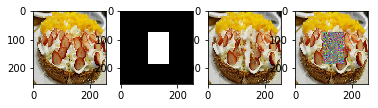

In [44]:
# show the final result 

f = plt.figure()
f.add_subplot(1,4, 1)
plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))


f.add_subplot(1,4, 2)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

f.add_subplot(1,4, 3)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))


f.add_subplot(1,4, 4)
plt.imshow(cv2.cvtColor(output_img2, cv2.COLOR_BGR2RGB))

plt.show(block=True)
